<a href="https://colab.research.google.com/github/Agungdecoco/Senitment-Analysis-with-SVM/blob/main/Senitment_Analysis_with_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.utils.multiclass import unique_labels

In [ ]:
file = pd.read_csv("/content/comments_ig_dataset_preprocessed_1.csv")
file.head()

,username,comments_clean,text_preprocessed,polarity_score,polarity
0,_opick_suaeb,jajaran keluarga rt yang dapat stb gratisss,"['jajar', 'keluarga', 'rt', 'stb', 'gratisss']",1,positive
1,shifa.rizki,apa ini akun kominfo isinya spam smua,"['akun', 'kominfo', 'isi', 'spam', 'smua']",-6,negative
2,alan_bw,hmm benahi support system biar seluruh channel...,"['hmm', 'benah', 'support', 'system', 'biar', ...",3,positive
3,samsir_adrian,ada yg sudah digital tapi belum hd ngga enak d...,"['yg', 'digital', 'hd', 'ngga', 'enak', 'tonto...",-9,negative
4,zaenaljr,ganti ke digital eh stasiun tv nya blom semua ...,"['ganti', 'digital', 'eh', 'stasiun', 'tv', 'n...",2,positive


In [ ]:
data_ = file[['comments_clean', 'polarity']]

In [ ]:
data_.describe()

,comments_clean,polarity
count,683,703
unique,331,3
top,hoax,negative
freq,4,358


In [ ]:
data = data_.dropna(axis=0)
data[['comments_clean']].drop("comments_clean",axis=1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
data.isna().sum()

comments_clean    0
polarity          0
dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data['comments_clean'].apply(lambda x: np.str_(x)), data['polarity'], test_size=0.2)

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [ ]:
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(data['comments_clean'])

X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)

In [ ]:
X_train_tfidf.shape

(546, 1702)

In [ ]:
y_train.shape

(546,)

In [ ]:
SVM = SVC()
SVM.fit(X_train_tfidf, y_train)

predict_svm = SVM.predict(X_test_tfidf)

print(accuracy_score(y_test, predict_svm)*100)
print(recall_score(y_test, predict_svm, average='macro')*100)  
print(precision_score(y_test, predict_svm, average='macro')*100)
print(f1_score(y_test, predict_svm, average='macro')*100)

89.05109489051095
85.27777777777779
94.31818181818183
88.55009724574941


In [ ]:
hyperparameters = {'kernel' :('linear', 'rbf'), 'C':[1,10]}
svm_ = SVC()
svm_tuned = GridSearchCV(svm_, hyperparameters, cv=5)

In [ ]:
svm_tuned.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [ ]:
print("Best C:", svm_tuned.best_estimator_.C)
print("Best kernel:", svm_tuned.best_estimator_.kernel)
print("Best score:", svm_tuned.best_score_)

Best C: 10
Best kernel: linear
Best score: 0.8754962468723937


In [ ]:
svm_ = SVC(C=10, kernel='linear')
svm_.fit(X_train_tfidf, y_train)

SVC(C=10, kernel='linear')

In [ ]:
predict_svm_ = svm_.predict(X_test_tfidf)

print(accuracy_score(y_test, predict_svm_)*100)
print(recall_score(y_test, predict_svm_, average='macro')*100)  
print(precision_score(y_test, predict_svm_, average='macro')*100)
print(f1_score(y_test, predict_svm_, average='macro')*100)

89.78102189781022
88.37138508371386
89.03115663679043
88.57545433632392


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
  if not title:
    if normalize:
      title = 'Normalized oonfusion matrix'
    else:
      title = 'Confusion matrix without normalization'
  
  cm = confusion_matrix(y_true, y_pred)

  classes = unique_labels(y_true, y_pred)
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix without normalization')

  print(cm)

  fig, ax = plt.subplots()
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)

  ax.set(xticks=np.arange(cm.shape[1]),
         yticks=np.arange(cm.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title=title,
         ylabel='True Label',
         xlabel='Predicted Label')
  
  plt.setp(ax.get_xticklabels(), rotation=40, ha='right', rotation_mode='anchor')

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i,j], fmt),
              ha='center', va='center',
              color="white" if cm[i, j] > thresh else "black")
      
  fig.tight_layout()
  return ax

# np.set_printoptions(precision=2)

Confusion matrix without normalization
[[67  6  0]
 [ 2 36  2]
 [ 2  2 20]]


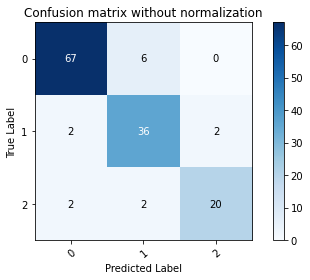

In [ ]:
class_names = y_test
plot_confusion_matrix(y_test, predict_svm_, classes=class_names,
                      title='Confusion matrix without normalization')

plt.show()

In [ ]:
def classify(comment):
  pred = svm_.predict(tfidf_vect.transform([comment]))
  if pred == 1:
    return pred, "Positive"
  elif pred == 2:
    return pred, "Negative"
  else:
    return pred, "Neutral"

In [ ]:
classify('bagus banget')

(array([0]), 'Neutral')